# Dataset to classify the severity of a road accident <br> 
Multi-class classification probelem based on real life dataset

In [274]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import (accuracy_score, 
                            classification_report,
                            recall_score, precision_score, f1_score,
                            confusion_matrix)
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.utils import resample

from sklearn import preprocessing

from imblearn.over_sampling import SMOTE



# Load dataset


In [275]:
alldata=pd.read_csv('RTA Dataset.csv')

In [276]:
alldata

,Time,Day_of_week,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Service_year_of_vehicle,...,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity
0,17:02:00,Monday,18-30,Male,Above high school,Employee,1-2yr,Automobile,Owner,Above 10yr,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury
1,17:02:00,Monday,31-50,Male,Junior high school,Employee,Above 10yr,Public (> 45 seats),Owner,5-10yrs,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury
2,17:02:00,Monday,18-30,Male,Junior high school,Employee,1-2yr,Lorry (41?100Q),Owner,NaN,...,Going straight,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury
3,1:06:00,Sunday,18-30,Male,Junior high school,Employee,5-10yr,Public (> 45 seats),Governmental,NaN,...,Going straight,Pedestrian,Female,18-30,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury
4,1:06:00,Sunday,18-30,Male,Junior high school,Employee,2-5yr,NaN,Owner,5-10yrs,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12311,16:15:00,Wednesday,31-50,Male,NaN,Employee,2-5yr,Lorry (11?40Q),Owner,NaN,...,Going straight,na,na,na,na,Driver,Normal,Not a Pedestrian,No distancing,Slight Injury
12312,18:00:00,Sunday,Unknown,Male,Elementary school,Employee,5-10yr,Automobile,Owner,NaN,...,Other,na,na,na,na,Driver,Normal,Not a Pedestrian,No distancing,Slight Injury
12313,13:55:00,Sunday,Over 51,Male,Junior high school,Employee,5-10yr,Bajaj,Owner,2-5yrs,...,Other,Driver or rider,Male,31-50,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Serious Injury
12314,13:55:00,Sunday,18-30,Female,Junior high school,Employee,Above 10yr,Lorry (41?100Q),Owner,2-5yrs,...,Other,na,na,na,na,Driver,Normal,Not a Pedestrian,Driving under the influence of drugs,Slight Injury


In [277]:
alldata['Accident_severity'].replace('Fatal injury','Fatal Injury',inplace=True)

In [278]:
alldata.columns

Index(['Time', 'Day_of_week', 'Age_band_of_driver', 'Sex_of_driver',
       'Educational_level', 'Vehicle_driver_relation', 'Driving_experience',
       'Type_of_vehicle', 'Owner_of_vehicle', 'Service_year_of_vehicle',
       'Defect_of_vehicle', 'Area_accident_occured', 'Lanes_or_Medians',
       'Road_allignment', 'Types_of_Junction', 'Road_surface_type',
       'Road_surface_conditions', 'Light_conditions', 'Weather_conditions',
       'Type_of_collision', 'Number_of_vehicles_involved',
       'Number_of_casualties', 'Vehicle_movement', 'Casualty_class',
       'Sex_of_casualty', 'Age_band_of_casualty', 'Casualty_severity',
       'Work_of_casuality', 'Fitness_of_casuality', 'Pedestrian_movement',
       'Cause_of_accident', 'Accident_severity'],
      dtype='object')

# Converting time column to datetime format

In [279]:
alldata['Time']=pd.to_datetime(alldata['Time'])
alldata['Time'].dt.hour

0        17
1        17
2        17
3         1
4         1
         ..
12311    16
12312    18
12313    13
12314    13
12315    13
Name: Time, Length: 12316, dtype: int64

# Initial data analysis

In [280]:
alldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12316 entries, 0 to 12315
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Time                         12316 non-null  datetime64[ns]
 1   Day_of_week                  12316 non-null  object        
 2   Age_band_of_driver           12316 non-null  object        
 3   Sex_of_driver                12316 non-null  object        
 4   Educational_level            11575 non-null  object        
 5   Vehicle_driver_relation      11737 non-null  object        
 6   Driving_experience           11487 non-null  object        
 7   Type_of_vehicle              11366 non-null  object        
 8   Owner_of_vehicle             11834 non-null  object        
 9   Service_year_of_vehicle      8388 non-null   object        
 10  Defect_of_vehicle            7889 non-null   object        
 11  Area_accident_occured        12077 non-nu

In [281]:
alldata.describe(include='all').T

C:\Users\v_tiw\AppData\Local\Temp\ipykernel_28288\676245324.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  alldata.describe(include='all').T


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Time,12316,1074,2022-12-10 15:30:00,120,2022-12-10 00:01:00,2022-12-10 23:59:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Day_of_week,12316,7,Friday,2041,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age_band_of_driver,12316,5,18-30,4271,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex_of_driver,12316,3,Male,11437,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Educational_level,11575,7,Junior high school,7619,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vehicle_driver_relation,11737,4,Employee,9627,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Driving_experience,11487,7,5-10yr,3363,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Type_of_vehicle,11366,17,Automobile,3205,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Owner_of_vehicle,11834,4,Owner,10459,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Service_year_of_vehicle,8388,6,Unknown,2883,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [282]:
alldata.isna().sum()

Time                              0
Day_of_week                       0
Age_band_of_driver                0
Sex_of_driver                     0
Educational_level               741
Vehicle_driver_relation         579
Driving_experience              829
Type_of_vehicle                 950
Owner_of_vehicle                482
Service_year_of_vehicle        3928
Defect_of_vehicle              4427
Area_accident_occured           239
Lanes_or_Medians                385
Road_allignment                 142
Types_of_Junction               887
Road_surface_type               172
Road_surface_conditions           0
Light_conditions                  0
Weather_conditions                0
Type_of_collision               155
Number_of_vehicles_involved       0
Number_of_casualties              0
Vehicle_movement                308
Casualty_class                    0
Sex_of_casualty                   0
Age_band_of_casualty              0
Casualty_severity                 0
Work_of_casuality           

In [283]:
print(alldata.duplicated().sum())

0


In [284]:
alldata.nunique()

Time                           1074
Day_of_week                       7
Age_band_of_driver                5
Sex_of_driver                     3
Educational_level                 7
Vehicle_driver_relation           4
Driving_experience                7
Type_of_vehicle                  17
Owner_of_vehicle                  4
Service_year_of_vehicle           6
Defect_of_vehicle                 3
Area_accident_occured            14
Lanes_or_Medians                  7
Road_allignment                   9
Types_of_Junction                 8
Road_surface_type                 5
Road_surface_conditions           4
Light_conditions                  4
Weather_conditions                9
Type_of_collision                10
Number_of_vehicles_involved       6
Number_of_casualties              8
Vehicle_movement                 13
Casualty_class                    4
Sex_of_casualty                   3
Age_band_of_casualty              6
Casualty_severity                 4
Work_of_casuality           

converting the time column into hour and minute because there is no data for dates

In [285]:
alldata['Hours']=alldata['Time'].dt.hour
alldata['Minutes']=alldata['Time'].dt.minute
alldata=alldata.drop('Time',axis=1)

In [286]:
newcolumns=list(alldata.columns.values[-2:])+list(alldata.columns.values[:-2])
alldata=alldata[newcolumns]

# EDA 
Plotting the data in catergories for Exploratory Data Analysis(EDA)

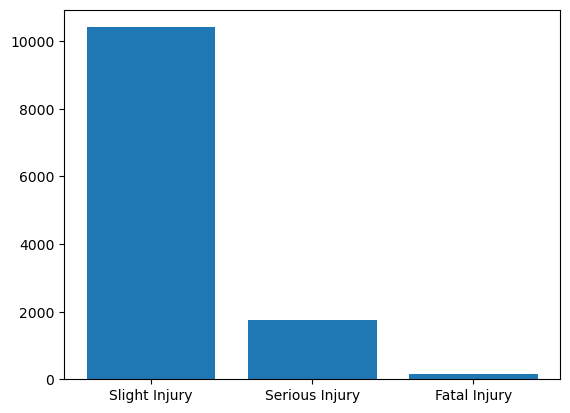

       Hours Day_of_week Age_band_of_driver Sex_of_driver   Educational_level  \
0         17      Monday              18-30          Male   Above high school   
1         17      Monday              31-50          Male  Junior high school   
2         17      Monday              18-30          Male  Junior high school   
3          1      Sunday              18-30          Male  Junior high school   
4          1      Sunday              18-30          Male  Junior high school   
...      ...         ...                ...           ...                 ...   
12311     16   Wednesday              31-50          Male                 NaN   
12312     18      Sunday            Unknown          Male   Elementary school   
12313     13      Sunday            Over 51          Male  Junior high school   
12314     13      Sunday              18-30        Female  Junior high school   
12315     13      Sunday              18-30          Male  Junior high school   

      Vehicle_driver_relati

In [287]:
xy=pd.DataFrame(alldata['Accident_severity'].value_counts())
xy.reset_index(inplace=True)
plt.bar(xy['index'],xy['Accident_severity'])
plt.show()
print(alldata.drop(['Minutes'],axis=1))

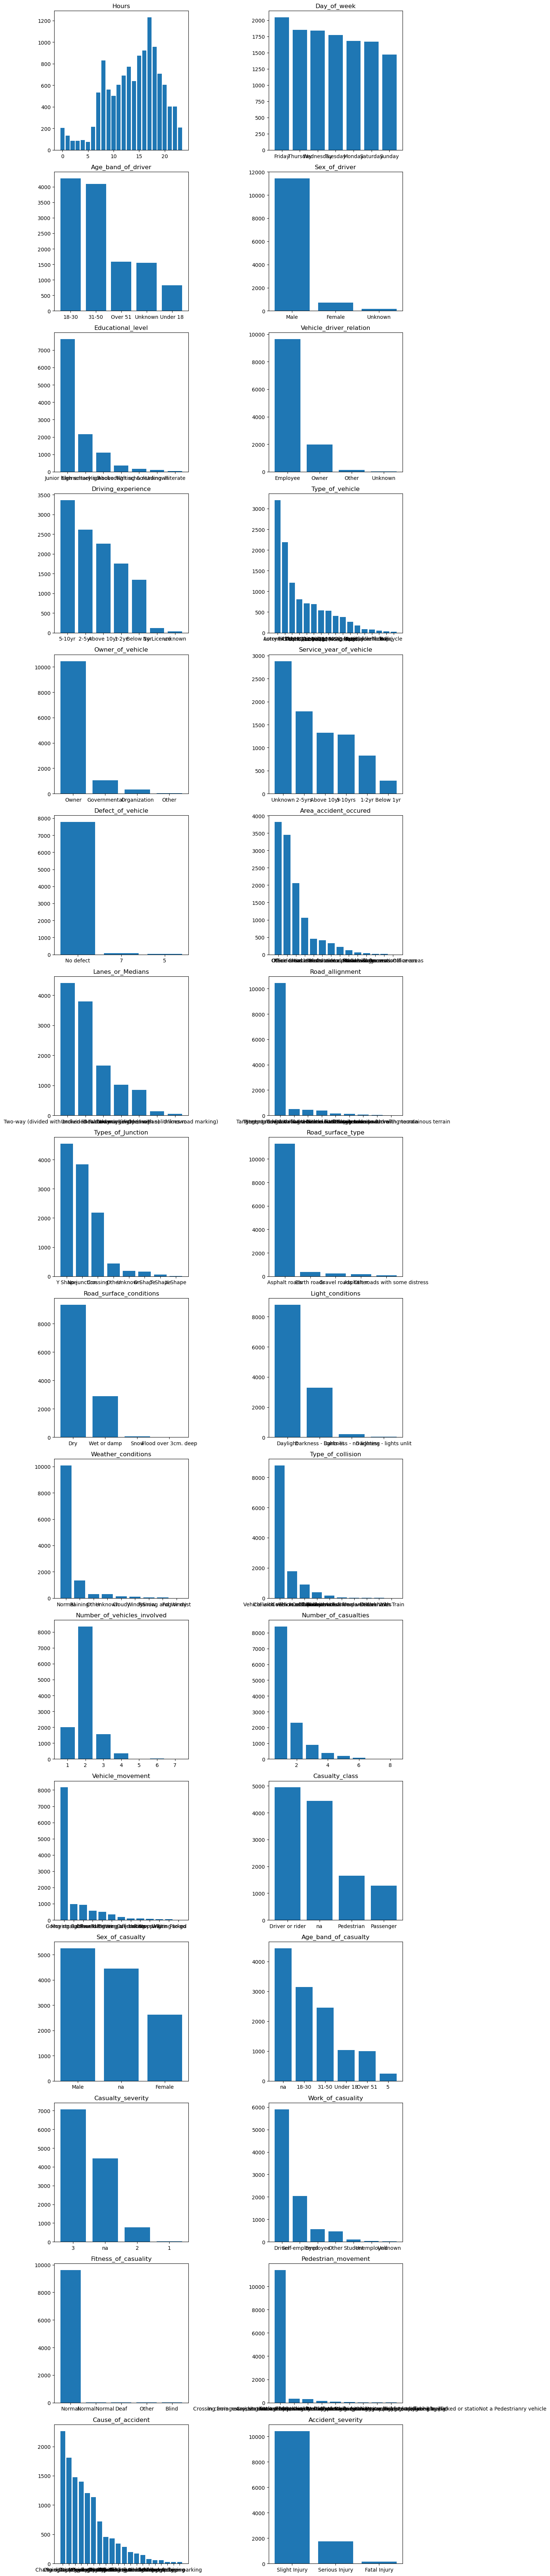

In [288]:
plt.figure(figsize=(15,70))
for ind,col in enumerate(alldata.drop(['Minutes'],axis=1)):
    xy=pd.DataFrame(alldata.drop(['Minutes'],axis=1)[col].value_counts())
    xy.reset_index(inplace=True)
    ax1=plt.subplot(16,2,ind+1)
    plt.bar(xy['index'],xy[col])
    plt.title(col)
    plt.tight_layout()
plt.show()

In [289]:
num_cols = alldata.dtypes[alldata.dtypes == 'int64'].index.tolist()
cat_cols = alldata.dtypes[alldata.dtypes != 'int64'].index.tolist()

# Preprocessing
imputing missing values with mode bc our data is highly skewed <br>
https://vitalflux.com/pandas-impute-missing-values-mean-median-mode/#Which_of_the_following_is_not_a_recommended_technique_for_imputing_missing_values_when_data_distribution_is_skewed

In [290]:
xy=[]
xy=alldata.isna().sum()[alldata.isna().sum() != 0].index.tolist()
for feat in xy:
    mode=alldata[feat].mode()[0]
    alldata[feat].fillna(mode,inplace=True)

# Encoding the data

In [291]:
le=preprocessing.LabelEncoder()
for column in alldata.drop(['Accident_severity'],axis=1):
    le.fit(alldata[column])
    alldata[column]=le.transform(alldata[column])

In [292]:
alldata

,Hours,Minutes,Day_of_week,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,...,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity
0,17,2,1,0,1,0,0,0,0,3,...,2,3,2,5,3,0,2,5,9,Slight Injury
1,17,2,1,1,1,4,0,3,11,3,...,2,3,2,5,3,0,2,5,16,Slight Injury
2,17,2,1,0,1,4,0,0,5,3,...,2,0,1,1,2,0,2,5,0,Serious Injury
3,1,6,3,0,1,4,0,2,11,0,...,2,2,0,0,2,0,2,5,1,Slight Injury
4,1,6,3,0,1,4,0,1,0,3,...,2,3,2,5,3,0,2,5,16,Slight Injury
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12311,16,15,6,1,1,4,0,1,4,3,...,2,3,2,5,3,0,2,5,10,Slight Injury
12312,18,0,3,4,1,1,0,2,0,3,...,4,3,2,5,3,0,2,5,10,Slight Injury
12313,13,55,3,2,1,4,0,2,1,3,...,4,0,1,1,2,0,2,5,1,Serious Injury
12314,13,55,3,0,0,4,0,3,5,3,...,4,3,2,5,3,0,2,5,5,Slight Injury


# Plotting the categories using the encoded data

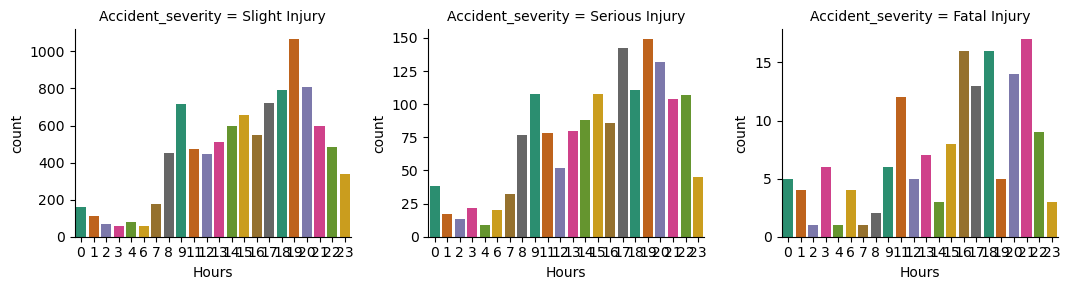

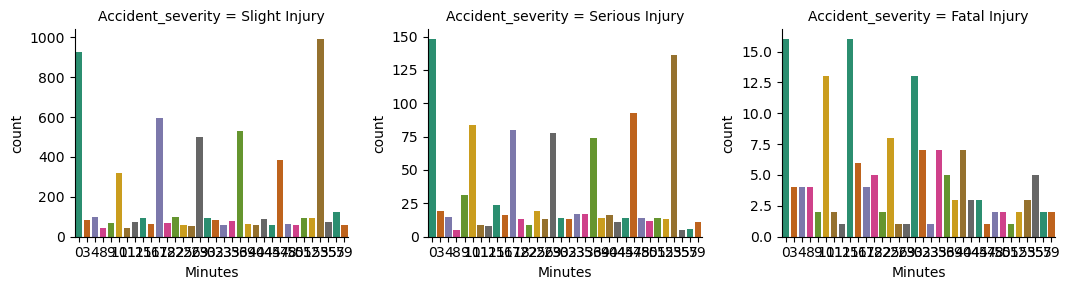

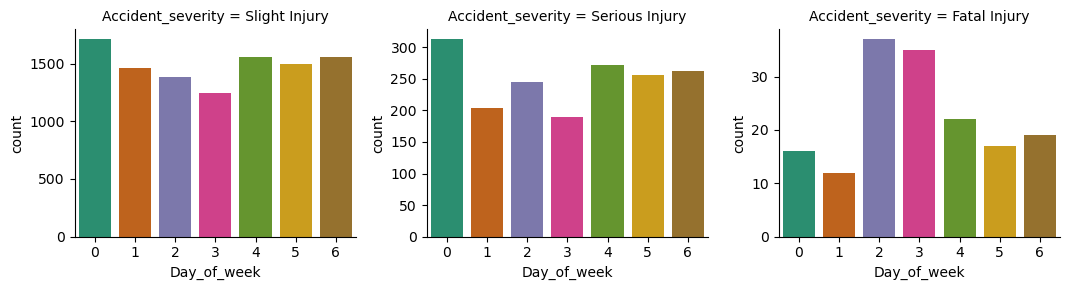

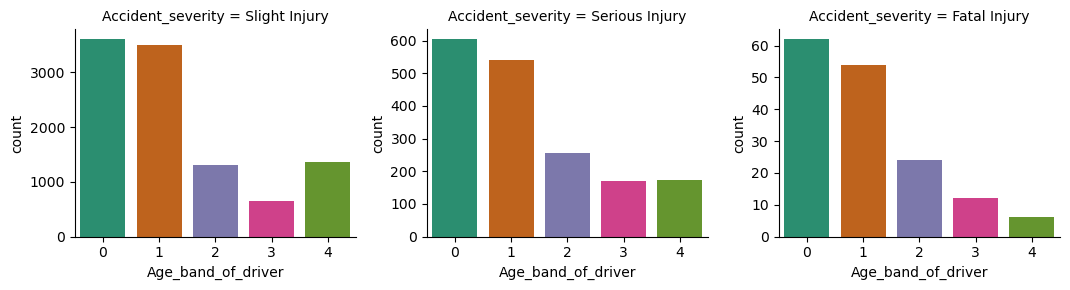

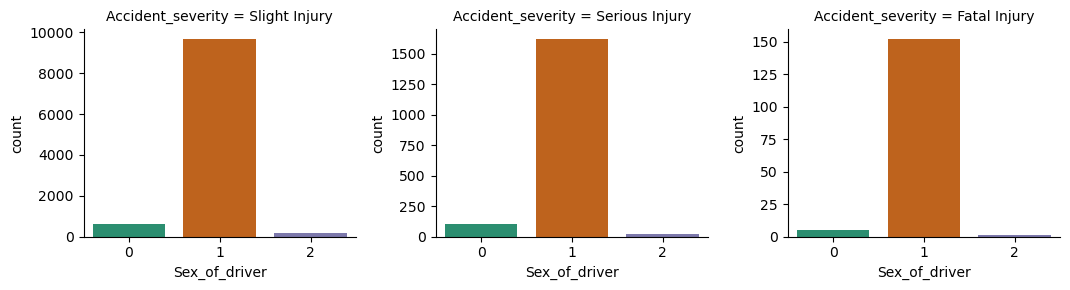

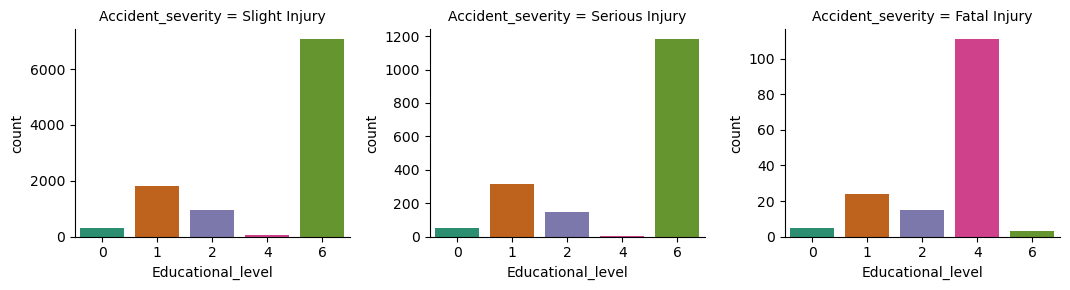

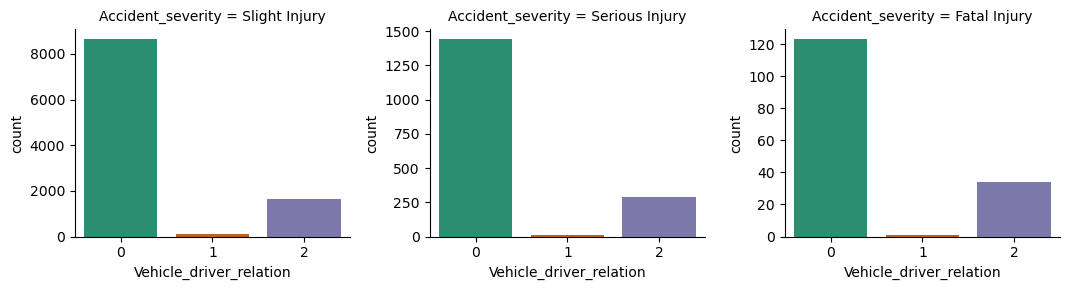

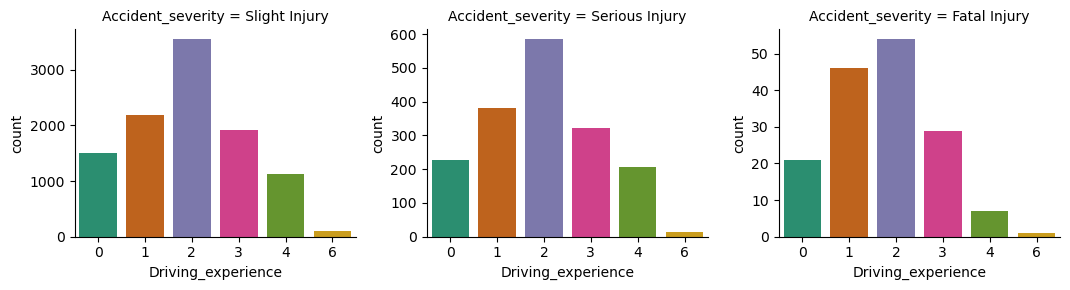

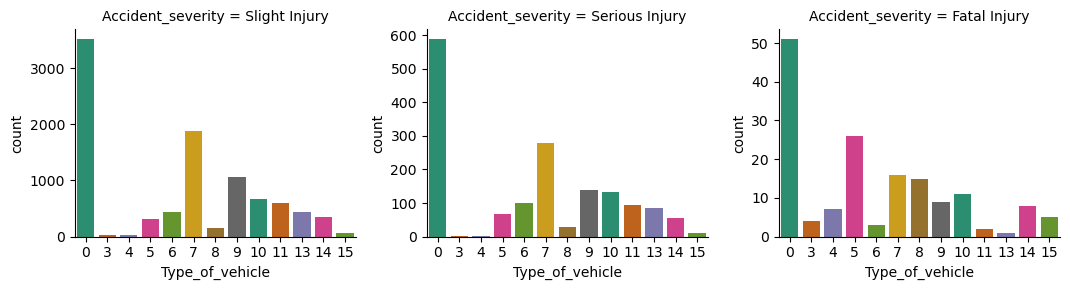

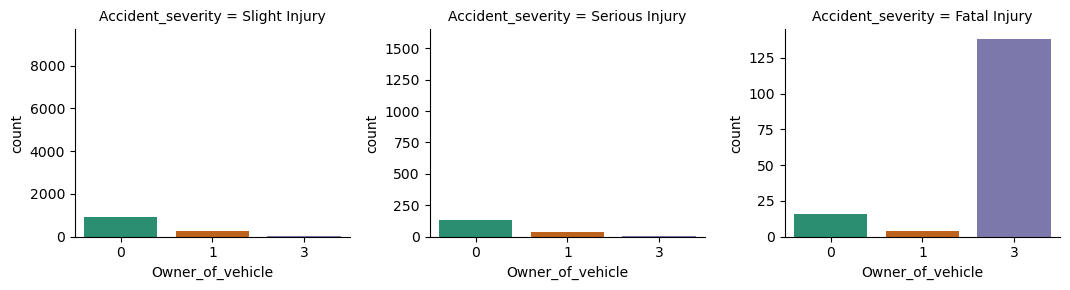

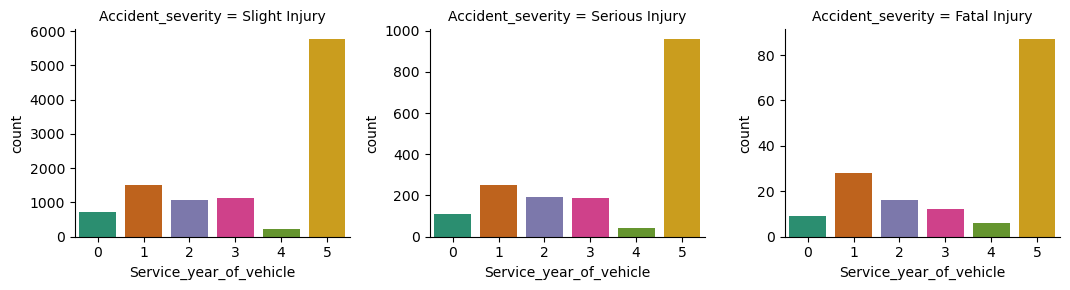

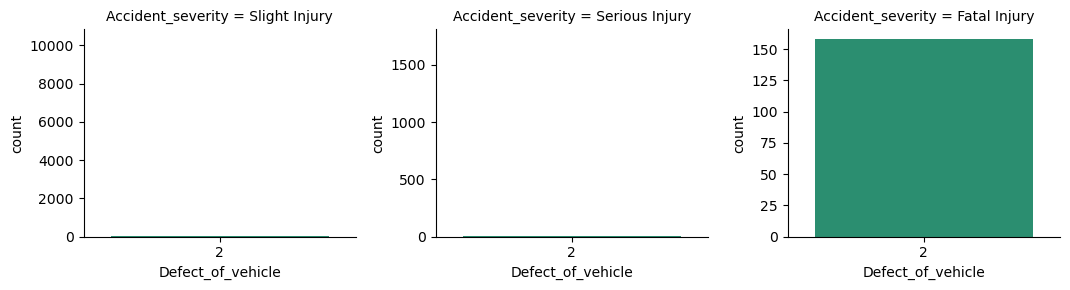

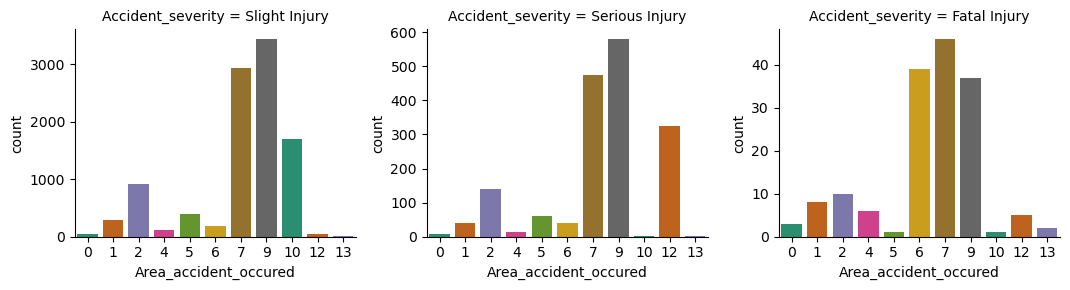

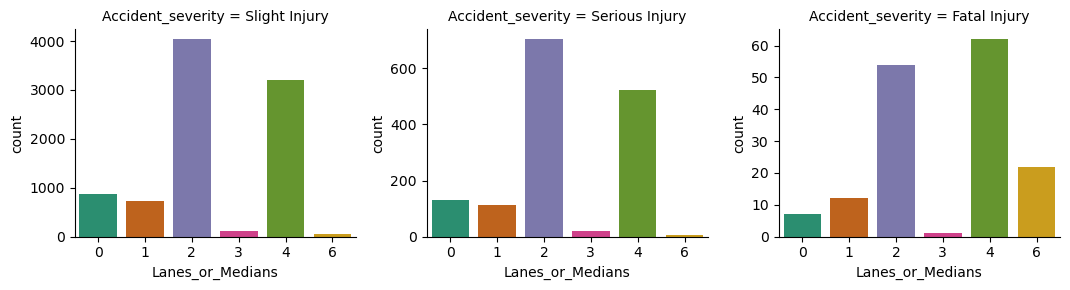

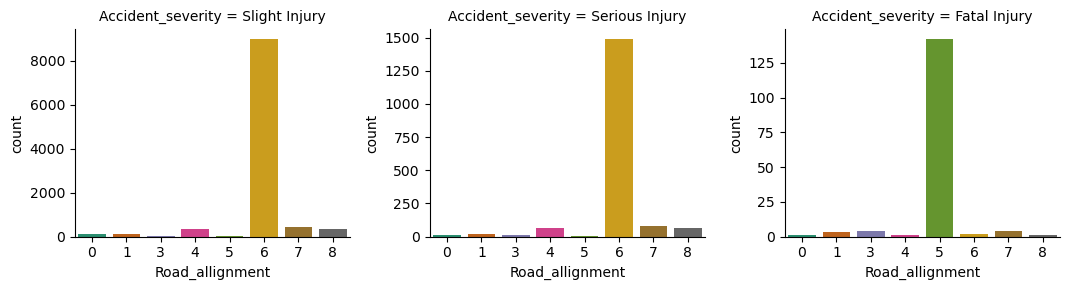

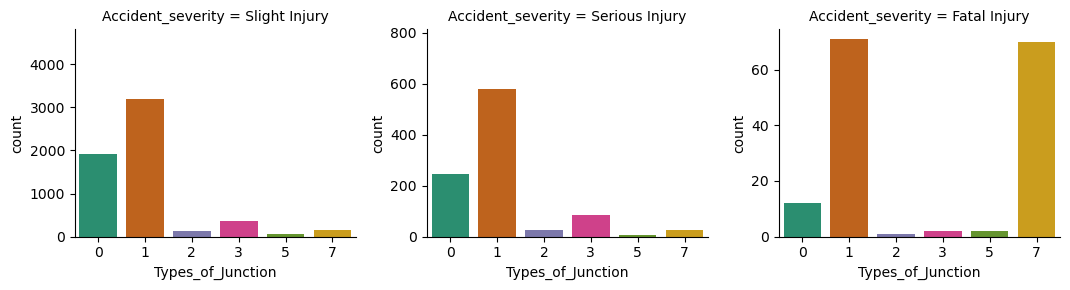

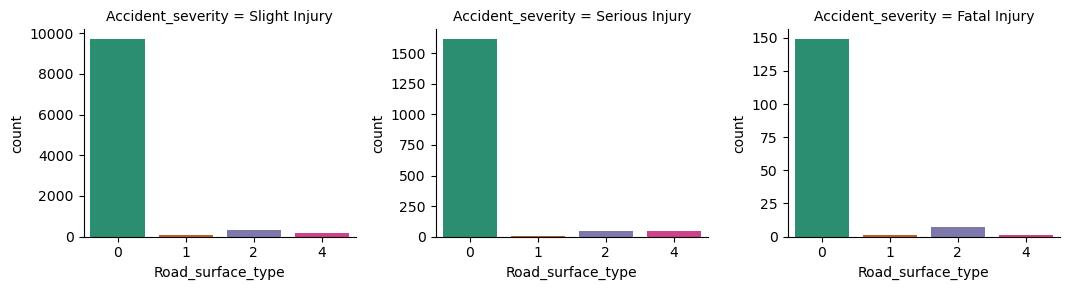

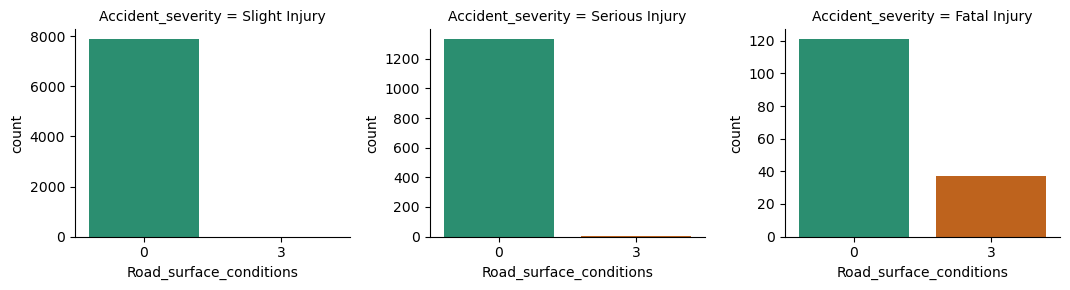

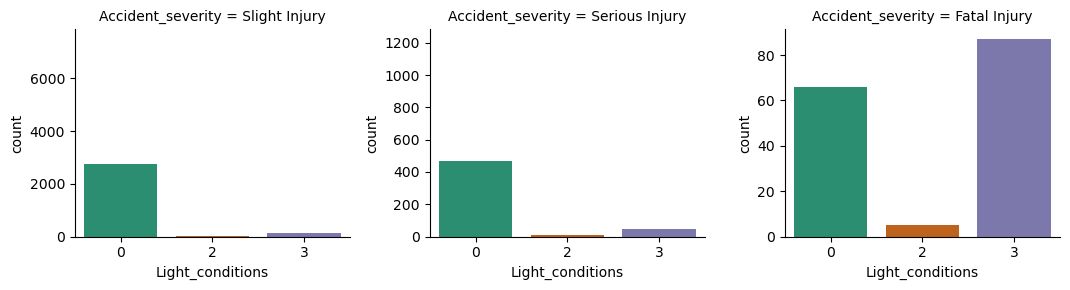

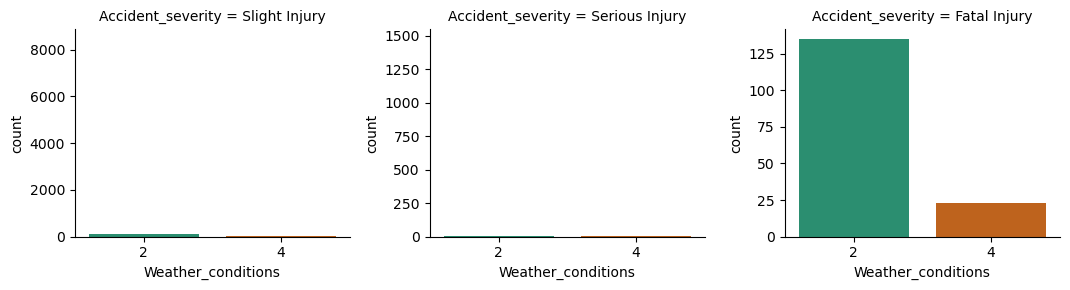

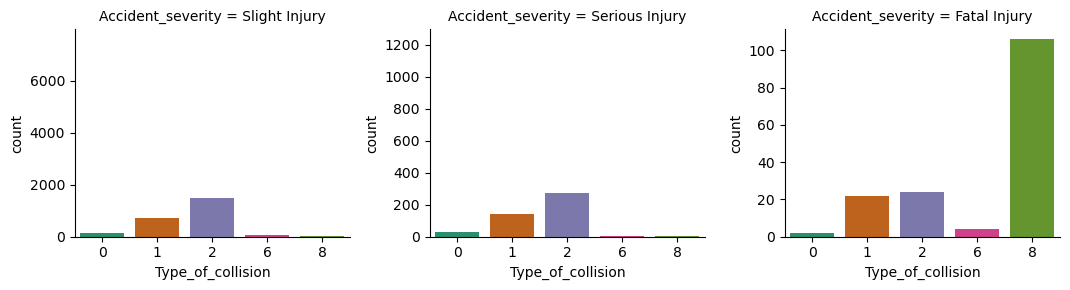

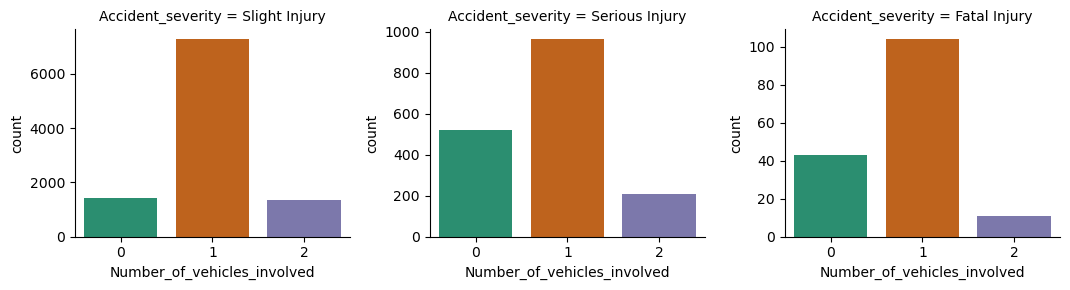

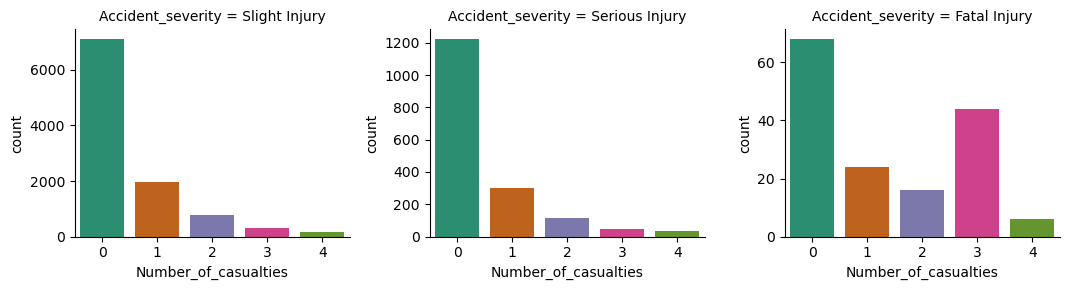

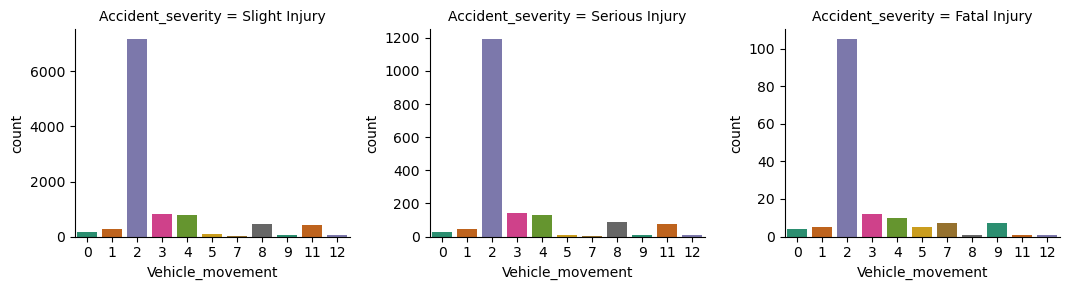

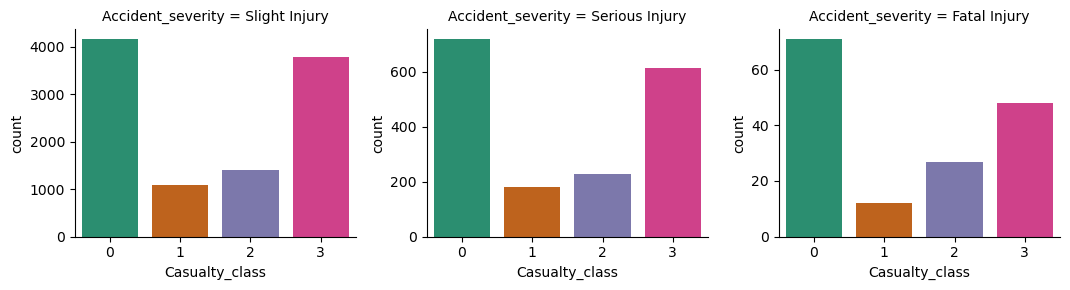

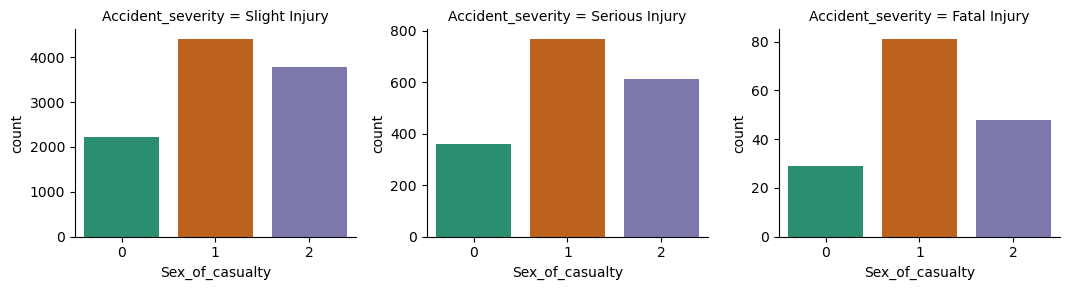

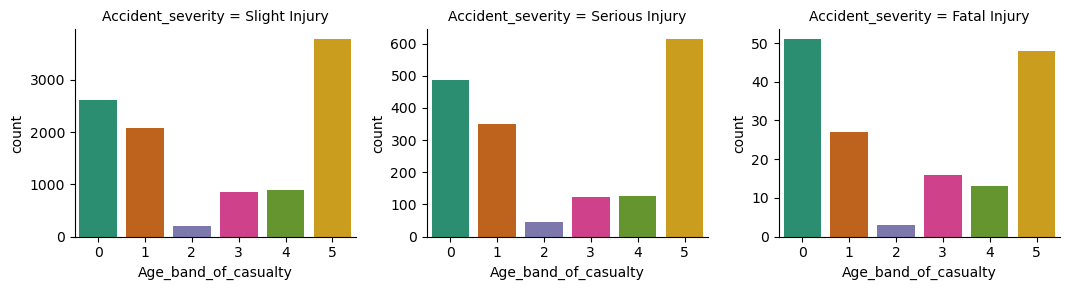

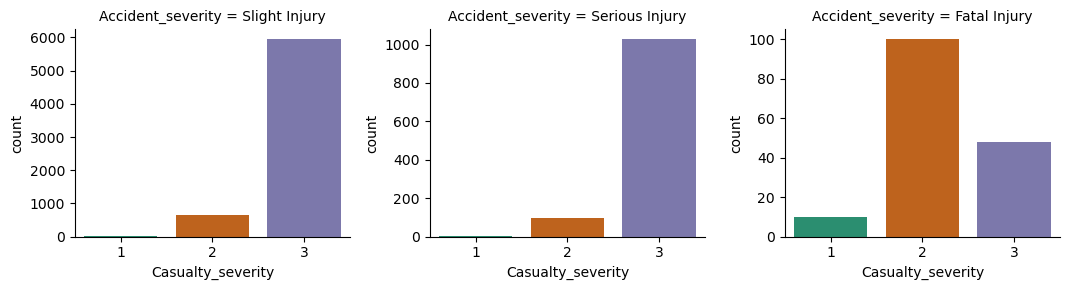

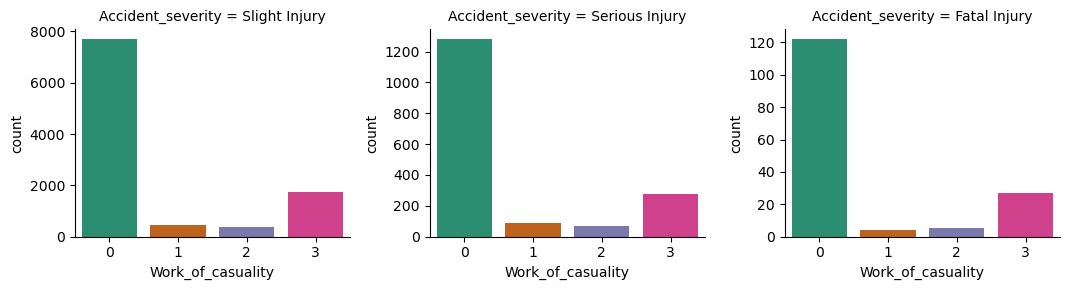

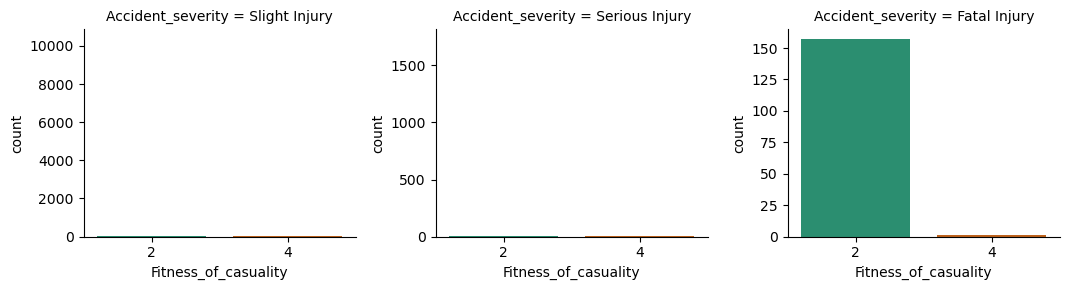

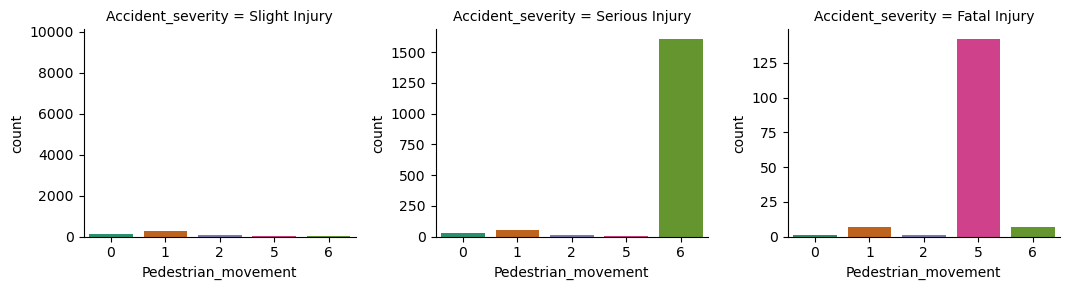

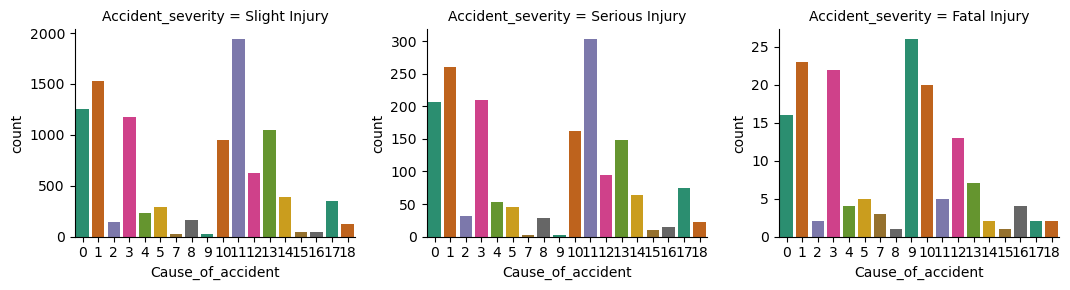

In [293]:
import warnings
warnings.filterwarnings( "ignore", module = "seaborn\..*" )

for col in newdata.drop('Accident_severity', axis=1):
    g = sns.FacetGrid(newdata, col='Accident_severity', aspect=1.2, sharey=False)
    g.map(sns.countplot, col, palette = 'Dark2')
    plt.show()

# Correlation between columns

<AxesSubplot:>

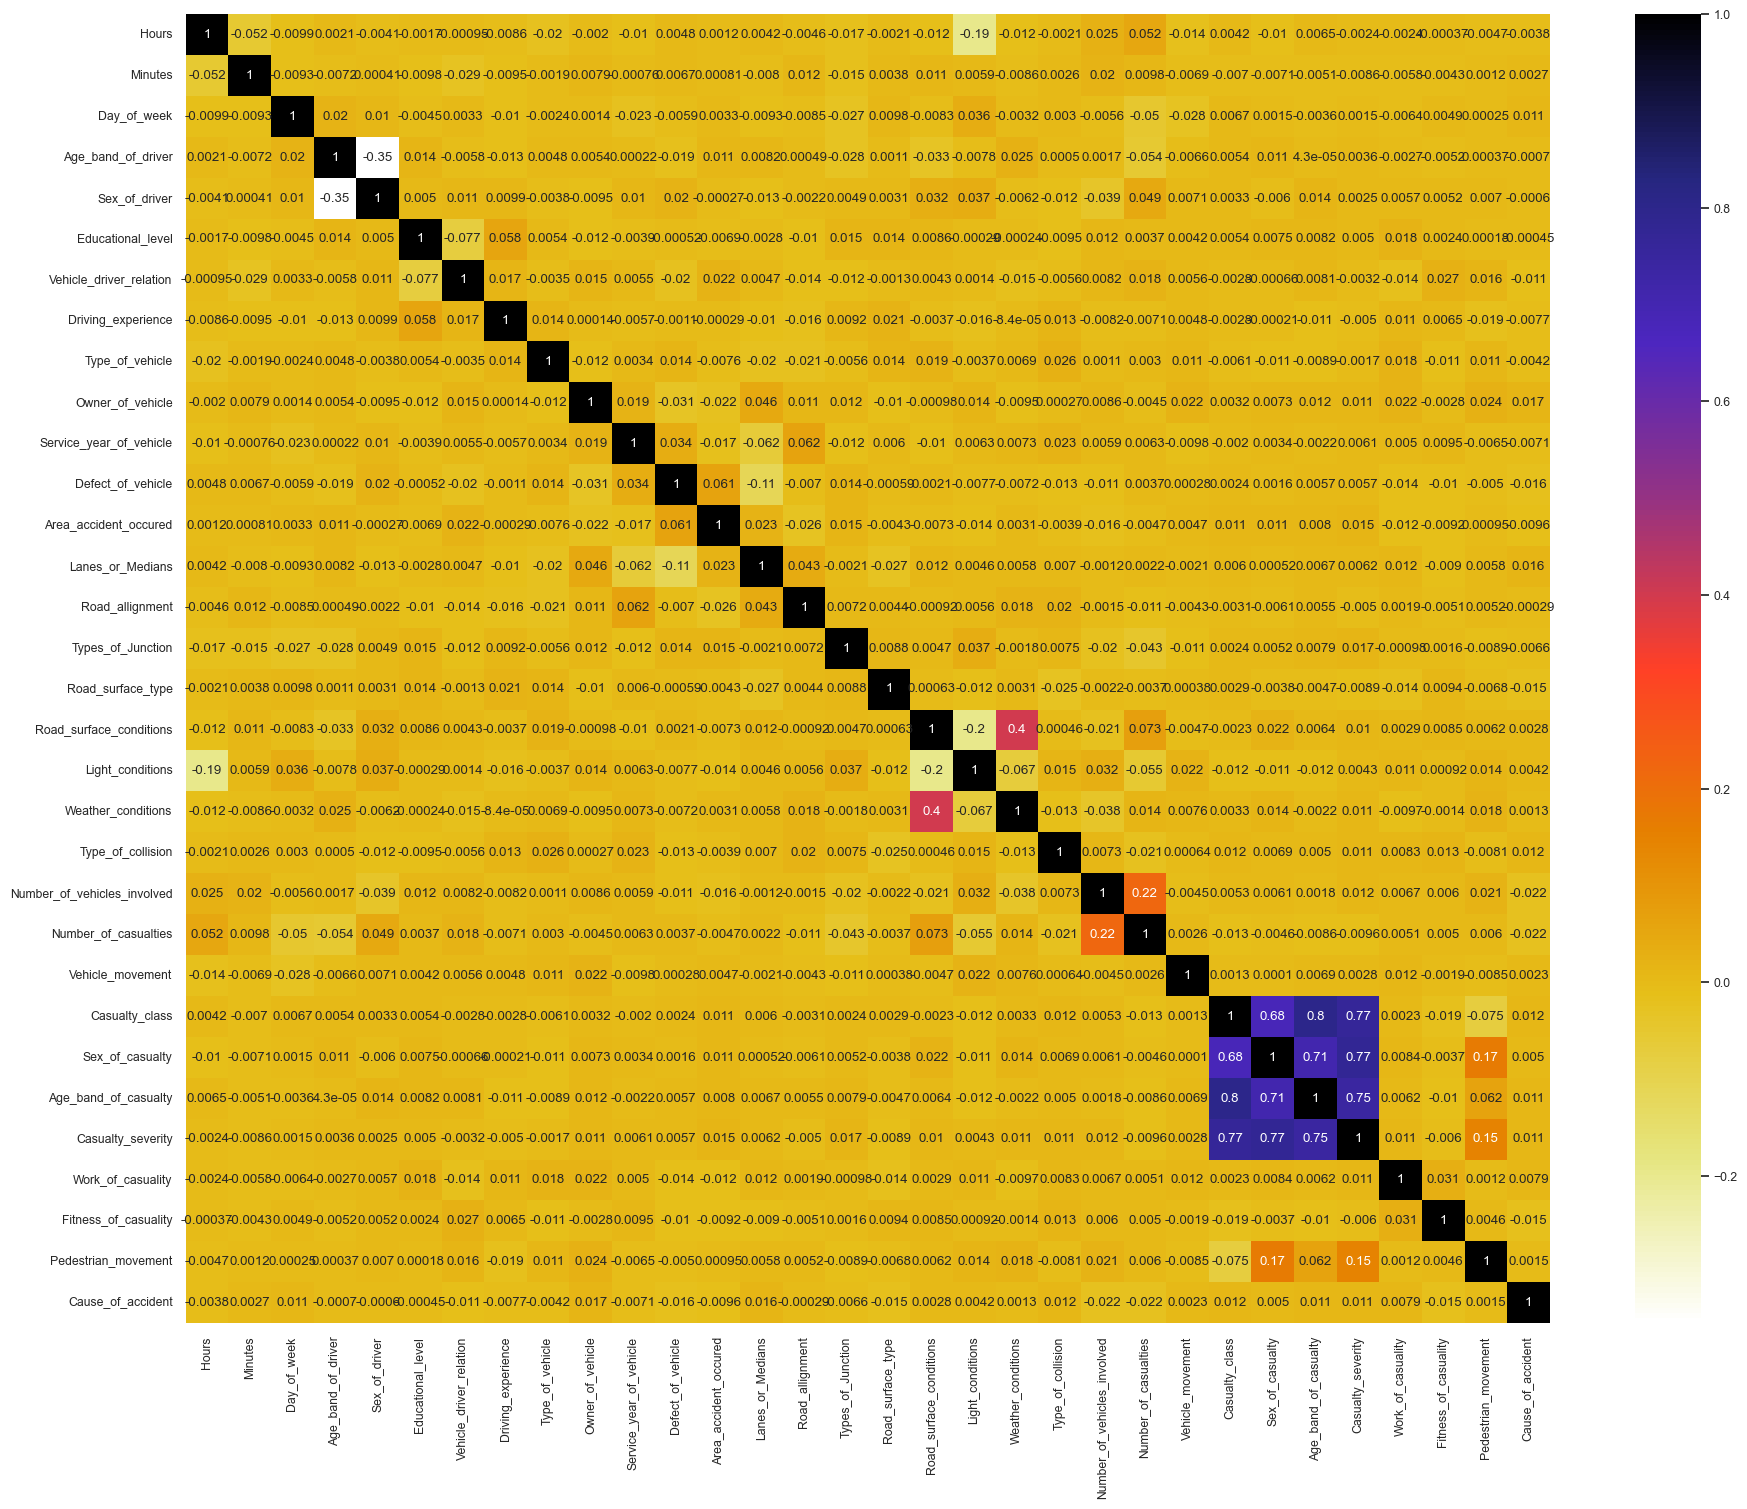

In [295]:
plt.figure(figsize=(22,17))
sns.set(font_scale=0.8)
sns.heatmap(newdata.corr(), annot=True, cmap=plt.cm.CMRmap_r)

# train test split

In [296]:

x = alldata.drop('Accident_severity', axis=1)
y = alldata['Accident_severity']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

y_train=pd.DataFrame(y_train)
y_test=pd.DataFrame(y_test)

# Upsampling the data because of imbalance

ysl=y_train[y_train['Accident_severity']=='Slight Injury']
yse=y_train[y_train['Accident_severity']=='Serious Injury']
yfa=y_train[y_train['Accident_severity']=='Fatal Injury']

print(ysl.shape[0],yse.shape[0],yfa.shape[0])


oversample = SMOTE()
x_train, y_train = oversample.fit_resample(x_train, y_train)

y_train=pd.DataFrame(y_train)
y_test=pd.DataFrame(y_test)

ysl=y_train[y_train['Accident_severity']=='Slight Injury']
yse=y_train[y_train['Accident_severity']=='Serious Injury']
yfa=y_train[y_train['Accident_severity']=='Fatal Injury']

print(ysl.shape[0],yse.shape[0],yfa.shape[0])


# encoding the target column
ley=preprocessing.LabelEncoder()
ley.fit(y_train['Accident_severity'])
y_test=ley.transform(y_test['Accident_severity'])
y_train=ley.transform(y_train['Accident_severity'])


(8621, 32) (3695, 32) (8621,) (3695,)
7324 1191 106
7324 7324 7324


# Baseline modelling using Xtree, XGBoost, RandFor

In [297]:
def modelling(X_train, y_train, X_test, y_test, **kwargs):
    scores = {}
    models = []
    if 'xgb' in kwargs.keys() and kwargs['xgb']:
        xgb = XGBClassifier()
        xgb.fit(X_train._get_numeric_data(), np.ravel(y_train, order='C'))
        y_pred = xgb.predict(X_test._get_numeric_data())
        scores['xgb']= [accuracy_score(y_test, y_pred),precision_score(y_test,y_pred,average='weighted'),recall_score(y_test,y_pred,average='weighted'),f1_score(y_test,y_pred,average='weighted')]
        
#         scores['xgb']['roc_auc'] = roc_auc_score(y_test, y_pred)
        models.append(xgb)

    if 'rf' in kwargs.keys() and kwargs['rf']:
        rf = RandomForestClassifier(n_estimators=200)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        scores['rf']= [accuracy_score(y_test, y_pred),precision_score(y_test,y_pred,average='weighted'),recall_score(y_test,y_pred,average='weighted'),f1_score(y_test,y_pred,average='weighted')]
        models.append(rf)

    if 'extree' in kwargs.keys() and kwargs['extree']:
        extree = ExtraTreesClassifier()
        extree.fit(X_train, y_train)
        y_pred = extree.predict(X_test)
        scores['extree']= [accuracy_score(y_test, y_pred),precision_score(y_test,y_pred,average='weighted'),recall_score(y_test,y_pred,average='weighted'),f1_score(y_test,y_pred,average='weighted')]
#         scores['extree']['roc_auc'] = roc_auc_score(y_test, y_pred)
        models.append(extree)
        
    return scores

# fitting the data using XGBoost, RandomForest, EXtree and looking at their scores accuracry, precision, recall, F1

In [298]:
modelling(x_train,y_train, x_test, y_test, xgb=True, rf=True, extree=True)

{'xgb': [0.8089309878213803,
  0.7681210032519062,
  0.8089309878213803,
  0.7828096867523574],
 'rf': [0.8029769959404601,
  0.7603995549167822,
  0.8029769959404601,
  0.7764596995930255],
 'extree': [0.8143437077131258,
  0.7681523523615339,
  0.8143437077131258,
  0.7767911245626367]}

# Since extratrees classifier works best we choose this for hyperparameter tuning

In [300]:
extr = ExtraTreesClassifier()
extr.fit(x_train,y_train)
y_pred = extr.predict(x_test)
print(confusion_matrix(y_test,y_pred))
print([accuracy_score(y_test, y_pred),precision_score(y_test,y_pred,average='weighted'),recall_score(y_test,y_pred,average='weighted'),f1_score(y_test,y_pred,average='weighted')])

extr.get_params()

[[   1    3   48]
 [   0   54  498]
 [   0  157 2934]]
[0.8089309878213803, 0.7570561510816936, 0.8089309878213803, 0.7686329010053508]


{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
#%%time
#gkf=KFold(n_splits=3,shuffle=True,random_state=123).split(X=x_train,y=y_train)
#params={  
# 'criterion':['gini', 'entropy', 'log_loss'],
# 'max_depth': [item for item in np.arange(1,20,1)],
# 'n_estimators':[ item for item in range(100,1000,50)],
#}
#
#extr=ExtraTreesClassifier()
#gsearch = GridSearchCV(
#    estimator= extr,
#    param_grid= params,
#    scoring='f1_weighted',
#    n_jobs=-1,
#    cv=gkf,
#    verbose=1,
#)
#
#extrmodel=gsearch.fit(X=x_train,y=y_train)
#(gsearch.best_params_,gsearch.best_score_)

Fitting 3 folds for each of 1026 candidates, totalling 3078 fits
Wall time: 50min 49s


({'criterion': 'log_loss', 'max_depth': 19, 'n_estimators': 800},
 0.9411517107347991)

# Using the best parameters to obtain the classification

In [301]:
extr = ExtraTreesClassifier(min_samples_split=2,criterion='log_loss',max_depth=19,n_estimators=800)
extr.fit(x_train,y_train)
y_pred = extr.predict(x_test)
print(confusion_matrix(y_test,y_pred))
print([accuracy_score(y_test, y_pred),precision_score(y_test,y_pred,average='weighted'),recall_score(y_test,y_pred,average='weighted'),f1_score(y_test,y_pred,average='weighted')])

[[   2    4   46]
 [   1   69  482]
 [   1  176 2914]]
[0.8078484438430311, 0.7566459999702353, 0.8078484438430311, 0.7730052119704072]


After hyperparameter tuning the model performance didn't imporove much infact it decreased from ~81% to ~80%. This could be because while training we used data for training and tested the accuracy on test set. On the other hand when we used grid search cv we trained and tested the accuracy on the training data. Hence it got less data to train therefore a small drop of accuracy.